In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
from model import ModelCreator
from datapipeline import DatasetCreator
import shutil

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
BACKBONE = 'resnet50'

In [4]:
heigh = 256

In [5]:
#model = sm.Unet(BACKBONE, encoder_weights='imagenet')
modelcreator = ModelCreator()
model = modelcreator.buildmodel()
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), name='conv2d_transpose_6/Sigmoid:0', description="created by layer 'conv2d_transpose_6'")


In [6]:
#dataset = DatasetCreator(sm.get_preprocessing(BACKBONE))
dataset = DatasetCreator(modelcreator.getpreprocess())

In [7]:
valdata = dataset('crosval/val/*png','castom-masks/masks_machine/',albu.Compose([albu.Resize(heigh,heigh,always_apply=True)]))
len(valdata)

8

In [8]:
testaugmentation = albu.Compose([
    albu.Resize(heigh,heigh,always_apply=True),
    albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    albu.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    albu.HorizontalFlip(p=0.5),
    albu.RandomRotate90(),
    albu.GaussianBlur(),
    albu.GaussNoise(),
    albu.Transpose(),
    ])

In [9]:
traindata = dataset('crosval/train/*png','castom-masks/masks_machine/',testaugmentation)
len(traindata)

18

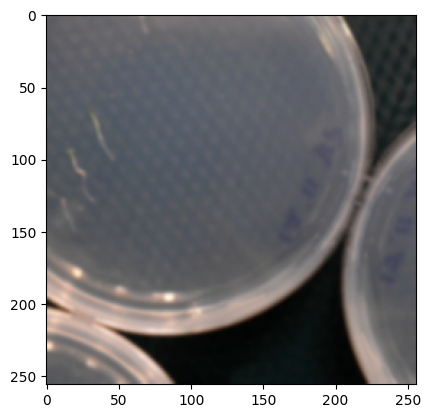

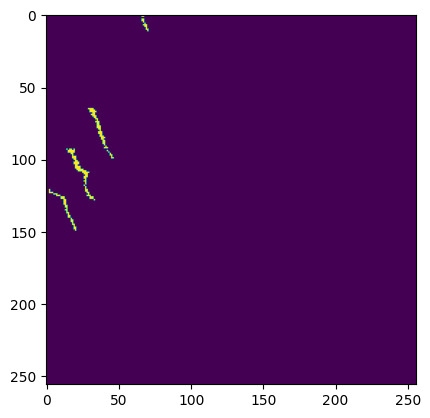

In [10]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

In [11]:
#tf.keras.utils.plot_model(model)

In [12]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1) if epoch > 10 and epoch % 10 == 0 else lr

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=20,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='libbestmodel/',save_best_only=True,monitor='val_loss',verbose=1)
]

In [13]:
# fit model
model_history = model.fit(
    traindata,
    epochs=1000,
    validation_data=valdata,
    callbacks=callback,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/1000
18/18 [==============================] - ETA: 0s - loss: 2.1105 - iou_score: 0.0105
Epoch 1: val_loss improved from inf to 4.87427, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 23s 699ms/step - loss: 2.1105 - iou_score: 0.0105 - val_loss: 4.8743 - val_iou_score: 0.0117 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/1000
17/18 [===========================>..] - ETA: 0s - loss: 1.2339 - iou_score: 0.0123
Epoch 2: val_loss improved from 4.87427 to 1.38541, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 594ms/step - loss: 1.2306 - iou_score: 0.0122 - val_loss: 1.3854 - val_iou_score: 0.0057 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/1000
17/18 [===========================>..] - ETA: 0s - loss: 1.0957 - iou_score: 0.0171
Epoch 3: val_loss improved from 1.38541 to 1.10426, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 14s 583ms/step - loss: 1.0946 - iou_score: 0.0184 - val_loss: 1.1043 - val_iou_score: 0.0071 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/1000
17/18 [===========================>..] - ETA: 0s - loss: 1.0567 - iou_score: 0.0276
Epoch 4: val_loss improved from 1.10426 to 1.07502, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 597ms/step - loss: 1.0564 - iou_score: 0.0276 - val_loss: 1.0750 - val_iou_score: 0.0098 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/1000
17/18 [===========================>..] - ETA: 0s - loss: 1.0256 - iou_score: 0.0436
Epoch 5: val_loss improved from 1.07502 to 1.04412, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 593ms/step - loss: 1.0260 - iou_score: 0.0429 - val_loss: 1.0441 - val_iou_score: 0.0215 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/1000
17/18 [===========================>..] - ETA: 0s - loss: 1.0001 - iou_score: 0.0614
Epoch 6: val_loss improved from 1.04412 to 1.04319, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 593ms/step - loss: 0.9988 - iou_score: 0.0639 - val_loss: 1.0432 - val_iou_score: 0.0189 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 7/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.9747 - iou_score: 0.0808
Epoch 7: val_loss improved from 1.04319 to 1.04191, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 591ms/step - loss: 0.9756 - iou_score: 0.0790 - val_loss: 1.0419 - val_iou_score: 0.0214 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 8/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.9516 - iou_score: 0.0992
Epoch 8: val_loss improved from 1.04191 to 1.02583, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 596ms/step - loss: 0.9535 - iou_score: 0.0947 - val_loss: 1.0258 - val_iou_score: 0.0295 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 9/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.9319 - iou_score: 0.1146
Epoch 9: val_loss improved from 1.02583 to 1.01160, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 583ms/step - loss: 0.9354 - iou_score: 0.1094 - val_loss: 1.0116 - val_iou_score: 0.0448 - lr: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 10/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.8775 - iou_score: 0.1633
Epoch 10: val_loss improved from 1.01160 to 1.00751, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 589ms/step - loss: 0.8788 - iou_score: 0.1602 - val_loss: 1.0075 - val_iou_score: 0.0464 - lr: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 11/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.8441 - iou_score: 0.1951
Epoch 11: val_loss did not improve from 1.00751
18/18 [==============================] - 8s 189ms/step - loss: 0.8436 - iou_score: 0.1946 - val_loss: 1.0127 - val_iou_score: 0.0446 - lr: 0.0010

Epoch 12: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 12/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.8271 - iou_score: 0.2144
Epoch 12: val_loss improved from 1.00751 to 0.98996, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 14s 589ms/step - loss: 0.8275 - iou_score: 0.2140 - val_loss: 0.9900 - val_iou_score: 0.0729 - lr: 0.0010

Epoch 13: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 13/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.8315 - iou_score: 0.2129
Epoch 13: val_loss improved from 0.98996 to 0.94954, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 594ms/step - loss: 0.8298 - iou_score: 0.2150 - val_loss: 0.9495 - val_iou_score: 0.1020 - lr: 0.0010

Epoch 14: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 14/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7959 - iou_score: 0.2448
Epoch 14: val_loss improved from 0.94954 to 0.93753, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 597ms/step - loss: 0.7952 - iou_score: 0.2451 - val_loss: 0.9375 - val_iou_score: 0.1096 - lr: 0.0010

Epoch 15: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 15/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7908 - iou_score: 0.2490
Epoch 15: val_loss did not improve from 0.93753
18/18 [==============================] - 8s 201ms/step - loss: 0.7955 - iou_score: 0.2390 - val_loss: 0.9377 - val_iou_score: 0.1243 - lr: 0.0010

Epoch 16: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 16/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7702 - iou_score: 0.2726
Epoch 16: val_loss improved from 0.93753 to 0.91187, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 600ms/step - loss: 0.7700 - iou_score: 0.2722 - val_loss: 0.9119 - val_iou_score: 0.1445 - lr: 0.0010

Epoch 17: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 17/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7739 - iou_score: 0.2673
Epoch 17: val_loss improved from 0.91187 to 0.88106, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 589ms/step - loss: 0.7713 - iou_score: 0.2732 - val_loss: 0.8811 - val_iou_score: 0.1658 - lr: 0.0010

Epoch 18: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 18/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7608 - iou_score: 0.2819
Epoch 18: val_loss improved from 0.88106 to 0.84604, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 593ms/step - loss: 0.7619 - iou_score: 0.2785 - val_loss: 0.8460 - val_iou_score: 0.2088 - lr: 0.0010

Epoch 19: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 19/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7339 - iou_score: 0.3030
Epoch 19: val_loss did not improve from 0.84604
18/18 [==============================] - 8s 196ms/step - loss: 0.7363 - iou_score: 0.2981 - val_loss: 0.8546 - val_iou_score: 0.2091 - lr: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7408 - iou_score: 0.2990
Epoch 20: val_loss improved from 0.84604 to 0.83760, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 591ms/step - loss: 0.7412 - iou_score: 0.2988 - val_loss: 0.8376 - val_iou_score: 0.2178 - lr: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 21/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7253 - iou_score: 0.3148
Epoch 21: val_loss improved from 0.83760 to 0.80641, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 594ms/step - loss: 0.7290 - iou_score: 0.3063 - val_loss: 0.8064 - val_iou_score: 0.2444 - lr: 9.0484e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 22/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7327 - iou_score: 0.3079
Epoch 22: val_loss did not improve from 0.80641
18/18 [==============================] - 8s 200ms/step - loss: 0.7344 - iou_score: 0.3045 - val_loss: 0.8308 - val_iou_score: 0.2101 - lr: 9.0484e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 23/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7141 - iou_score: 0.3237
Epoch 23: val_loss improved from 0.80641 to 0.80452, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 592ms/step - loss: 0.7160 - iou_score: 0.3196 - val_loss: 0.8045 - val_iou_score: 0.2597 - lr: 9.0484e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 24/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7225 - iou_score: 0.3165
Epoch 24: val_loss improved from 0.80452 to 0.77612, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 590ms/step - loss: 0.7245 - iou_score: 0.3135 - val_loss: 0.7761 - val_iou_score: 0.2697 - lr: 9.0484e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 25/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7187 - iou_score: 0.3193
Epoch 25: val_loss did not improve from 0.77612
18/18 [==============================] - 8s 197ms/step - loss: 0.7190 - iou_score: 0.3183 - val_loss: 0.7840 - val_iou_score: 0.2799 - lr: 9.0484e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 26/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7375 - iou_score: 0.3014
Epoch 26: val_loss improved from 0.77612 to 0.76587, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 597ms/step - loss: 0.7370 - iou_score: 0.3045 - val_loss: 0.7659 - val_iou_score: 0.2852 - lr: 9.0484e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 27/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7393 - iou_score: 0.3026
Epoch 27: val_loss did not improve from 0.76587
18/18 [==============================] - 8s 198ms/step - loss: 0.7381 - iou_score: 0.3040 - val_loss: 0.7769 - val_iou_score: 0.2765 - lr: 9.0484e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 28/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7278 - iou_score: 0.3133
Epoch 28: val_loss improved from 0.76587 to 0.74424, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 594ms/step - loss: 0.7251 - iou_score: 0.3185 - val_loss: 0.7442 - val_iou_score: 0.3067 - lr: 9.0484e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 29/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6986 - iou_score: 0.3401
Epoch 29: val_loss improved from 0.74424 to 0.73888, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 591ms/step - loss: 0.6958 - iou_score: 0.3449 - val_loss: 0.7389 - val_iou_score: 0.3135 - lr: 9.0484e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 30/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7114 - iou_score: 0.3276
Epoch 30: val_loss improved from 0.73888 to 0.73263, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 596ms/step - loss: 0.7105 - iou_score: 0.3301 - val_loss: 0.7326 - val_iou_score: 0.3102 - lr: 9.0484e-04

Epoch 31: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 31/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7236 - iou_score: 0.3182
Epoch 31: val_loss did not improve from 0.73263
18/18 [==============================] - 8s 195ms/step - loss: 0.7207 - iou_score: 0.3239 - val_loss: 0.7698 - val_iou_score: 0.2829 - lr: 8.1873e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 32/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6942 - iou_score: 0.3450
Epoch 32: val_loss improved from 0.73263 to 0.72628, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 589ms/step - loss: 0.6967 - iou_score: 0.3392 - val_loss: 0.7263 - val_iou_score: 0.3153 - lr: 8.1873e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 33/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6987 - iou_score: 0.3392
Epoch 33: val_loss improved from 0.72628 to 0.71535, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 591ms/step - loss: 0.6974 - iou_score: 0.3421 - val_loss: 0.7154 - val_iou_score: 0.3394 - lr: 8.1873e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 34/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6929 - iou_score: 0.3478
Epoch 34: val_loss improved from 0.71535 to 0.68500, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 588ms/step - loss: 0.6973 - iou_score: 0.3378 - val_loss: 0.6850 - val_iou_score: 0.3601 - lr: 8.1873e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 35/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.7029 - iou_score: 0.3349
Epoch 35: val_loss did not improve from 0.68500
18/18 [==============================] - 8s 196ms/step - loss: 0.7018 - iou_score: 0.3391 - val_loss: 0.7169 - val_iou_score: 0.3270 - lr: 8.1873e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 36/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6777 - iou_score: 0.3591
Epoch 36: val_loss did not improve from 0.68500
18/18 [==============================] - 8s 199ms/step - loss: 0.6767 - iou_score: 0.3623 - val_loss: 0.7435 - val_iou_score: 0.3156 - lr: 8.1873e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 37/1000


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 593ms/step - loss: 0.6768 - iou_score: 0.3628 - val_loss: 0.6803 - val_iou_score: 0.3644 - lr: 7.4082e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 49/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6693 - iou_score: 0.3680
Epoch 49: val_loss did not improve from 0.68028
18/18 [==============================] - 8s 198ms/step - loss: 0.6698 - iou_score: 0.3681 - val_loss: 0.6814 - val_iou_score: 0.3621 - lr: 7.4082e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 50/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6763 - iou_score: 0.3643
Epoch 50: val_loss did not improve from 0.68028
18/18 [==============================] - 8s 197ms/step - loss: 0.6788 - iou_score: 0.3584 - val_loss: 0.6922 - val_iou_score: 0.3591 - lr: 7.4082e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 51/1000
17/

INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 588ms/step - loss: 0.6730 - iou_score: 0.3663 - val_loss: 0.6707 - val_iou_score: 0.3742 - lr: 6.0653e-04

Epoch 64: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 64/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6466 - iou_score: 0.3901
Epoch 64: val_loss did not improve from 0.67071
18/18 [==============================] - 8s 201ms/step - loss: 0.6469 - iou_score: 0.3891 - val_loss: 0.6924 - val_iou_score: 0.3553 - lr: 6.0653e-04

Epoch 65: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 65/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6600 - iou_score: 0.3785
Epoch 65: val_loss did not improve from 0.67071
18/18 [==============================] - 8s 200ms/step - loss: 0.6614 - iou_score: 0.3747 - val_loss: 0.6893 - val_iou_score: 0.3611 - lr: 6.0653e-04

Epoch 66: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 66/1000


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 14s 586ms/step - loss: 0.6718 - iou_score: 0.3699 - val_loss: 0.6534 - val_iou_score: 0.3897 - lr: 5.4881e-04

Epoch 74: LearningRateScheduler setting learning rate to 0.0005488114547915757.
Epoch 74/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6468 - iou_score: 0.3896
Epoch 74: val_loss did not improve from 0.65342
18/18 [==============================] - 8s 197ms/step - loss: 0.6528 - iou_score: 0.3786 - val_loss: 0.6727 - val_iou_score: 0.3769 - lr: 5.4881e-04

Epoch 75: LearningRateScheduler setting learning rate to 0.0005488114547915757.
Epoch 75/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6572 - iou_score: 0.3810
Epoch 75: val_loss did not improve from 0.65342
18/18 [==============================] - 8s 192ms/step - loss: 0.6554 - iou_score: 0.3839 - val_loss: 0.6973 - val_iou_score: 0.3556 - lr: 5.4881e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.0005488114547915757.
Epoch 76/1000


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 587ms/step - loss: 0.6564 - iou_score: 0.3801 - val_loss: 0.6510 - val_iou_score: 0.4031 - lr: 4.9659e-04

Epoch 87: LearningRateScheduler setting learning rate to 0.0004965850966982543.
Epoch 87/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6676 - iou_score: 0.3708
Epoch 87: val_loss did not improve from 0.65099
18/18 [==============================] - 8s 191ms/step - loss: 0.6629 - iou_score: 0.3790 - val_loss: 0.6525 - val_iou_score: 0.3994 - lr: 4.9659e-04

Epoch 88: LearningRateScheduler setting learning rate to 0.0004965850966982543.
Epoch 88/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6594 - iou_score: 0.3781
Epoch 88: val_loss did not improve from 0.65099
18/18 [==============================] - 8s 190ms/step - loss: 0.6590 - iou_score: 0.3780 - val_loss: 0.6523 - val_iou_score: 0.3916 - lr: 4.9659e-04

Epoch 89: LearningRateScheduler setting learning rate to 0.0004965850966982543.
Epoch 89/1000


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 14s 585ms/step - loss: 0.6607 - iou_score: 0.3798 - val_loss: 0.6485 - val_iou_score: 0.3921 - lr: 4.0657e-04

Epoch 106: LearningRateScheduler setting learning rate to 0.0004065694229211658.
Epoch 106/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6360 - iou_score: 0.3984
Epoch 106: val_loss did not improve from 0.64849
18/18 [==============================] - 8s 190ms/step - loss: 0.6359 - iou_score: 0.4001 - val_loss: 0.6566 - val_iou_score: 0.3875 - lr: 4.0657e-04

Epoch 107: LearningRateScheduler setting learning rate to 0.0004065694229211658.
Epoch 107/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6419 - iou_score: 0.3950
Epoch 107: val_loss did not improve from 0.64849
18/18 [==============================] - 8s 191ms/step - loss: 0.6451 - iou_score: 0.3874 - val_loss: 0.6623 - val_iou_score: 0.3869 - lr: 4.0657e-04

Epoch 108: LearningRateScheduler setting learning rate to 0.0004065694229211658.
Epoch 1

INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 605ms/step - loss: 0.6255 - iou_score: 0.4099 - val_loss: 0.6435 - val_iou_score: 0.4009 - lr: 3.6788e-04

Epoch 119: LearningRateScheduler setting learning rate to 0.00036787919816561043.
Epoch 119/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6240 - iou_score: 0.4098
Epoch 119: val_loss did not improve from 0.64350
18/18 [==============================] - 8s 195ms/step - loss: 0.6240 - iou_score: 0.4116 - val_loss: 0.6639 - val_iou_score: 0.3842 - lr: 3.6788e-04

Epoch 120: LearningRateScheduler setting learning rate to 0.00036787919816561043.
Epoch 120/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6532 - iou_score: 0.3847
Epoch 120: val_loss did not improve from 0.64350
18/18 [==============================] - 8s 191ms/step - loss: 0.6492 - iou_score: 0.3917 - val_loss: 0.6662 - val_iou_score: 0.3837 - lr: 3.6788e-04

Epoch 121: LearningRateScheduler setting learning rate to 0.0003328708407934755.
Epoch

INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


18/18 [==============================] - 15s 591ms/step - loss: 0.6508 - iou_score: 0.3852 - val_loss: 0.6298 - val_iou_score: 0.4149 - lr: 3.3287e-04

Epoch 128: LearningRateScheduler setting learning rate to 0.0003328708407934755.
Epoch 128/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6300 - iou_score: 0.4039
Epoch 128: val_loss did not improve from 0.62983
18/18 [==============================] - 8s 195ms/step - loss: 0.6314 - iou_score: 0.4024 - val_loss: 0.6502 - val_iou_score: 0.3951 - lr: 3.3287e-04

Epoch 129: LearningRateScheduler setting learning rate to 0.0003328708407934755.
Epoch 129/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6402 - iou_score: 0.3966
Epoch 129: val_loss did not improve from 0.62983
18/18 [==============================] - 8s 201ms/step - loss: 0.6407 - iou_score: 0.3960 - val_loss: 0.6538 - val_iou_score: 0.3913 - lr: 3.3287e-04

Epoch 130: LearningRateScheduler setting learning rate to 0.0003328708407934755.
Epoch 1

In [14]:
testdata = dataset('crosval/test/*png','castom-masks/masks_machine/',albu.Compose([albu.Resize(heigh,heigh,always_apply=True)]))

In [15]:
results = model.evaluate(testdata)
results

3/3 [==============================] - 1s 226ms/step - loss: 0.5472 - iou_score: 0.4869


[0.5472477674484253, 0.4869173467159271]

In [16]:
i = 0

if os.path.isdir('output/'):
    shutil.rmtree('output/')
os.makedirs('output/')

for img in testdata.take(len(testdata)):
    for image in img[0]:
        mask = model.predict((tf.reshape(image,[1,heigh,heigh,3])))
        mask = tf.keras.utils.array_to_img(mask[0])
        img = tf.keras.utils.array_to_img(image)
        img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
        vis = np.concatenate((img, mask), axis=1)
        i+=1
        cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 22ms/step
